# objective :
<br>1. Applying logistic regression to classify the amazon food reviews.
<br>2. Check for different types of scoring metrics
<br>3. Getting the important features.
<br>4. checking for multicollinearity

In [1]:
#importing all module
import sqlite3 as s
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix


from scipy.sparse import find

#importing the needed module
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

#importing the needed module
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con=s.connect("database.sqlite")
con

In [3]:
data=pd.read_sql_query("SELECT * FROM Reviews WHERE Score!=3",con)
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#function to change the score to positive/negative
def change(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'

In [5]:
a_s=data.Score
a_s=a_s.map(change)
data.Score=a_s
data.Score.head(5)

0    positive
1    negative
2    positive
3    negative
4    positive
Name: Score, dtype: object

# Data cleaning

The data needs to get clean as it may have some unwanted things such as duplicates.

In [6]:
#sorting the values by product ids
data=data.sort_values("ProductId")

In [7]:
#removing the duplicates from the data
final_data=data.drop_duplicates(subset={"UserId","Text","ProfileName","Time"},keep="first",inplace=False)

In [8]:
final_data=final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]

In [9]:
print(final_data.shape)
print(final_data.Score.value_counts())

(364171, 10)
positive    307061
negative     57110
Name: Score, dtype: int64


In [10]:
p_data=final_data[final_data.Score=="positive"]
n_data=final_data[final_data.Score=="negative"]

In [11]:
#randomly selecting points
p_data_w2v=p_data.sample(150000)
n_data_w2v=n_data.sample(12000)

In [12]:
print(p_data.shape,n_data.shape)

(307061, 10) (57110, 10)


In [13]:
d=pd.concat((p_data,n_data))
d_w2v=pd.concat((p_data_w2v,n_data_w2v))

In [14]:
print(d.shape)

(364171, 10)


In [15]:
#sorting according to time stamp
d=d.sort_values('Time')
d_w2v=d_w2v.sort_values('Time')

In [16]:
print(d.Score.value_counts())
print(d_w2v.Score.value_counts())

positive    307061
negative     57110
Name: Score, dtype: int64
positive    150000
negative     12000
Name: Score, dtype: int64


# Data preprocessing

The data should be preprocessed after cleaning it

In [17]:
import string 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [18]:
#stopwords
stop_words=set(stopwords.words("english"))
#initializing snowball stemmer
sno=SnowballStemmer("english")
print(stop_words)

{"you've", 'no', "should've", "didn't", 'shan', 'because', 'now', "doesn't", 'until', "shan't", "couldn't", 'hers', "haven't", 'will', 'myself', 'again', 'from', 'hadn', 'once', "you're", 'that', 'do', 'so', 'on', 'nor', 'itself', 'such', 'themselves', 'doing', 'while', 'your', 'what', 'how', 'their', 'if', 'he', 'any', 'all', 'ma', "it's", 'here', 'is', 'mightn', 'about', 'up', 'why', 'between', 'into', 'its', 'but', 'ourselves', "needn't", 'were', 'isn', 'y', "you'd", 'can', 'it', 'during', 'and', 'them', 'above', 'own', 'had', 'more', 'too', 's', 'just', 'don', "hasn't", 'ours', 'herself', 'off', 'an', "shouldn't", 'with', 'this', 'mustn', 'these', "she's", 'him', 'wouldn', 'down', 'only', 'wasn', 'further', 've', 'other', 'of', 'does', 'same', 'ain', 'himself', 'a', 'she', 'for', 'or', 'yourself', 'haven', 'they', 'needn', 'at', 'didn', 'yours', 'than', 'd', "won't", 'out', 'yourselves', 'each', 'few', 're', "isn't", 'where', 'm', 'won', 'the', 'am', 'being', 'which', 'against', 't

In [19]:
#function to remove html tags
def cleanhtml(s):
    cleanr=re.compile("<.*?>")
    cleant=re.sub(cleanr," ",s)
    return cleant

In [20]:
#funtion to remove punctuation and special character
def cleanpunc(s): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',s)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [21]:
i=0
final=[]

for s in d.Text.values:
    f=[]
    c=cleanhtml(s)
    for w in cleanpunc(c).split():
        if w.isalpha() and len(w)>2:
            if w not in stop_words:
                sne=(sno.stem(w.lower())).encode('utf-8')
                f.append(sne)
               
            else:
                continue
        else:
            continue
    te=b" ".join(f)
    final.append(te)
    i+=1

In [22]:
#adding the preprocessed data into another column
d["cleaned"]=final
d

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel f...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'this one movi that should your movi collect ...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli after hour tra...
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'what happen say name three time michael keat...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazi look beatlejuic french version vid...


In [23]:
#checking if new column is added
d.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'cleaned'],
      dtype='object')

In [24]:
import sqlite3
conn=sqlite3.connect("future.sqlite")
c=conn.cursor()
conn.text_factory=str
d.to_sql('Reviews',conn,if_exists='replace',index=True)

In [25]:
#replacing positive and negative with 1,0 to make it work for different metrics
d=d.replace(['positive','negative'],[1,0])
d.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel f...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'this one movi that should your movi collect ...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli after hour tra...
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'what happen say name three time michael keat...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazi look beatlejuic french version vid...


# Bag of words

In [26]:
#splitting 
x_1, x_test, y_1, y_test = train_test_split(d.cleaned.values, d.Score, test_size=0.3, random_state=0,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

In [27]:
print(x_1.shape,x_test.shape,y_1.shape,y_test.shape)

(254919,) (109252,) (254919,) (109252,)


In [28]:
#bigrams
count_vect=CountVectorizer(ngram_range=(1,2))

In [29]:
#transforming the data
bdata=count_vect.fit_transform(x_1)
#preprocessing the data
bdata=preprocessing.normalize(bdata)
#transforming the data
test_data=count_vect.transform(x_test)
#preprocessing the data
test_data=preprocessing.normalize(test_data)
print(bdata.shape,y_1.shape,test_data.shape,y_test.shape)

(254919, 2351241) (254919,) (109252, 2351241) (109252,)


In [30]:
#using the gridsearchcv for finding the best c
lr = LogisticRegression()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100],"penalty":["l1","l2"]} 
#For time based splitting
t = TimeSeriesSplit(n_splits=5) 
    
gsv = GridSearchCV(lr,param_grid,cv=t,n_jobs=-1,verbose=1,scoring="f1")
gsv.fit(bdata,y_1)
print("Best HyperParameter: ",gsv.best_params_)
#assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("best estimator: ",gsv.estimator)
    

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 12.8min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l2'}
best estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [31]:
gsv.best_score_*100

95.9740680876888

In [32]:
gsv.cv_results_

C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\

{'mean_fit_time': array([ 16.63749781,  20.83253603,  23.25176392,  24.08889909,
         47.01011367,  35.6068409 ,  54.66903248,  57.00446014,
         62.42787461, 103.62524829, 108.52031026, 178.52324286,
        157.93410149, 159.81724205]),
 'std_fit_time': array([13.39802197,  9.29681063,  9.30139419, 11.0702012 , 21.25689261,
        17.83793764, 20.41594066, 26.31793641, 25.54481749, 53.81259925,
        45.06210088, 89.72110796, 42.22490133, 44.85393228]),
 'mean_score_time': array([0.31299424, 0.7248939 , 0.24830265, 0.19129672, 0.23151498,
        0.18702321, 0.22707152, 0.20118022, 0.17680678, 0.2042418 ,
        0.20415545, 0.19411001, 0.20534668, 0.11184316]),
 'std_score_time': array([0.21530891, 0.65495301, 0.06519058, 0.01489942, 0.03607768,
        0.01986659, 0.0695942 , 0.0104857 , 0.0188051 , 0.02787597,
        0.04191677, 0.06072975, 0.03496602, 0.07222408]),
 'param_C': masked_array(data=[0.0001, 0.0001, 0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1,
                  

we can see that l1 and l2 are alternatively executed . so , lets separate the values.

In [33]:
#separating the regularization values
mean_test_score=gsv.cv_results_["mean_test_score"]
mean_test_score=1-mean_test_score
y_l1=[]
y_l2=[]
for i in mean_test_score[0:14:2]:
    y_l1.append(i)
for i in mean_test_score[1:14:2]:
    y_l2.append(i)
print(y_l1)
print("\n\n")
print(y_l2)

[0.08524499261752805, 0.08524499261752805, 0.08339273461120578, 0.06110914246917176, 0.04490086725962483, 0.04308681209550935, 0.04567310934270652]



[0.08524499261752805, 0.08524499261752805, 0.0848666413108411, 0.06595224081153384, 0.04772442038977054, 0.041022223684298975, 0.04025931912311187]


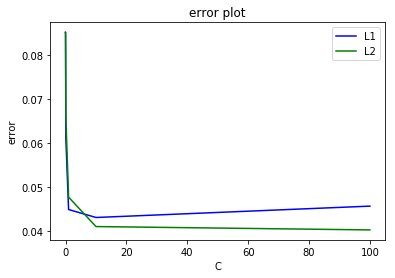

In [34]:
#plotting the error
x=param_grid["C"]
plt.plot(x,y_l1,"b",label="L1")
plt.plot(x,y_l2,"g",label="L2")
plt.xlabel("C")
plt.ylabel("error")
plt.title("error plot")
plt.legend()
plt.show()

now lets test the optimal value on test data

In [35]:
lr=LogisticRegression(C=100,penalty="l2")
lr.fit(bdata,y_1)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
pred=lr.predict(test_data)


the accuracy is 93.38%

the recall is 97.37%
the precision is 94.76%
the f1 score is 96.05%


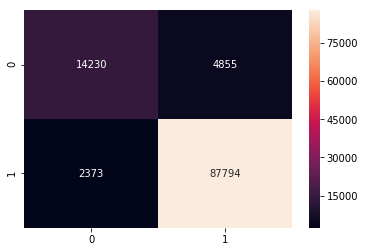

In [37]:
#different metrics
acc=accuracy_score(y_test,pred)*100
print("\nthe accuracy is %.2f%%"%acc)
    
re=recall_score(y_test,pred,) * 100
print("\nthe recall is %.2f%%"%re)
    
pre=precision_score(y_test,pred) * 100
print("the precision is %.2f%%"%pre)
    
f1=f1_score(y_test,pred) * 100
print("the f1 score is %.2f%%"%f1)

df_cm=pd.DataFrame(confusion_matrix(y_test,pred))
#sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,fmt="d")

In [38]:
scoring_data=pd.DataFrame({"accuracy":"93.38%","recall":"97.37%","precision":"94.76","f1":"96.05%"},index=["score"])
scoring_data.T

,score
accuracy,93.38%
recall,97.37%
precision,94.76
f1,96.05%


Lets see what happens to sparsity when lambda increases (c decreases) with L1 regularization

In [39]:
lr=LogisticRegression(C=1,penalty="l1")
lr.fit(bdata,y_1)
np.count_nonzero(lr.coef_)

2635

In [40]:
lr=LogisticRegression(C=0.1,penalty="l1")
lr.fit(bdata,y_1)
np.count_nonzero(lr.coef_)

453

In [41]:
lr=LogisticRegression(C=0.01,penalty="l1")
lr.fit(bdata,y_1)
np.count_nonzero(lr.coef_)

57

In [42]:
lr=LogisticRegression(C=0.001,penalty="l1")
lr.fit(bdata,y_1)
np.count_nonzero(lr.coef_)

1

sparsity increases with increase in lambda(decrease in C)

In [116]:
#randomizedsearchcv is used to find optimal c and regulariztion
lr = LogisticRegression()
param_grid = {'C':randint(10**-2, 10**2),"penalty":["l1","l2"]} 
#For time based splitting
t = TimeSeriesSplit(n_splits=5) 
    
rsv = RandomizedSearchCV(lr,param_grid,cv=t,n_jobs=-1,verbose=1)
rsv.fit(bdata,y_1)
print("Best HyperParameter: ",rsv.best_params_)
#assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("best estimator: ",rsv.estimator)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 20.1min finished


Best HyperParameter:  {'C': 79, 'penalty': 'l2'}
best estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


# Pertubation test
<br>This test is for multicollinearity check

In [43]:
#the data before adding noise
clf=LogisticRegression()
clf.fit(bdata,y_1)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
np.count_nonzero(clf.coef_)

2351241

In [59]:
wt_test=find(clf.coef_)[2]
print(wt_test[0:20])

[ 2.95206467e-02  2.92571924e-02  2.63454358e-04  1.61430043e-01
  1.15755606e-01  3.77762247e-03 -2.40949890e-02  2.48134930e-03
  6.32093536e-03  2.82106843e-03  1.56434515e-03  5.28477633e-04
  3.84257308e-02  1.56737879e-04  1.29260824e-03  1.29260824e-03
  6.07704500e-03  6.07704500e-03  9.78693576e-05  9.78693576e-05]


In [54]:
#randomling getting noise for all nonzero values
bdata_t=bdata
epsilon = np.random.uniform(low=-0.001, high=0.001, size=(find(bdata_t)[0].size,))
i,j,v=find(bdata_t)
print(epsilon)

[-5.63431474e-04 -1.93660834e-04 -5.35740061e-04 ...  9.67153780e-04
  3.86172824e-05 -1.22587320e-04]


In [55]:
find(bdata_t)[0].size

18114878

In [121]:
#adding the noise to nonzero value
bdata_t[i,j] = epsilon + bdata_t[i,j]

In [122]:
#the data after adding noise
cl=LogisticRegression()
cl.fit(bdata_t,y_1)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [123]:
np.count_nonzero(cl.coef_)

2351241

In [124]:
wt_test_noise=find(cl.coef_[0])[2]
print(wt_test_noise[0:20])

[ 2.95171555e-02  2.93880598e-02  2.55116481e-04  1.61207681e-01
  1.15946295e-01  3.77784478e-03 -2.39667566e-02  2.44735048e-03
  6.33426888e-03  2.77482622e-03  1.54081980e-03  5.32318649e-04
  3.83345599e-02  1.57880619e-04  1.31856287e-03  1.31021722e-03
  5.99185334e-03  5.98170349e-03  9.69787143e-05  9.73391520e-05]


As the difference between the values is not significant , features are not multicollinear

# Feature importance
<br>as the features are not mutlicollinear , we can use l1 regularization to get imp features

In [125]:
countvect=CountVectorizer(ngram_range=(1,2),stop_words="english",analyzer='word')
feature_data=countvect.fit_transform(x_1)
all_feat = countvect.get_feature_names()

In [126]:
clf=LogisticRegression(C=1,penalty="l1")
clf.fit(feature_data,y_1)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [127]:
#shape of the array
clf.coef_.shape

(1, 2209266)

In [128]:
#converting the array to one dimensional
check=clf.coef_.ravel()

In [129]:
#creating the dataframe for features importance
feature_importance=pd.DataFrame({"word":all_feat,"coef_":check})
feature_importance.head(4)

,word,coef_
0,aa,0.000000
1,aa pleas,0.000000
2,aa state,0.000000
3,aaa,0.028596


In [130]:
#sorting in the descending order
feature_importance.sort_values(by="coef_",ascending=False,inplace=True)
feature_importance.head(10)

,word,coef_
205612,bonsai today,6.236173
757031,food beverag,4.913268
632314,emeraldforest,4.634703
2170887,wont sorri,4.536133
1821192,spoke someon,4.239659
445276,correct mistak,4.223517
492910,damag contain,4.200272
1851394,stick wont,4.184966
963200,illi brand,4.107079
1855900,stomach bad,3.997220


Text(0.5,1,'important positive features ')

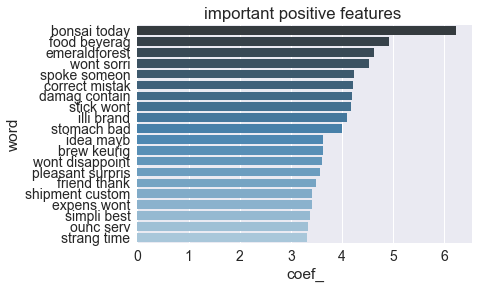

In [131]:
#visualising positive features
sns.barplot(y='word', x='coef_', data=feature_importance.head(20), palette="Blues_d").set_title('important positive features ')

Text(0.5,1,'important negative features')

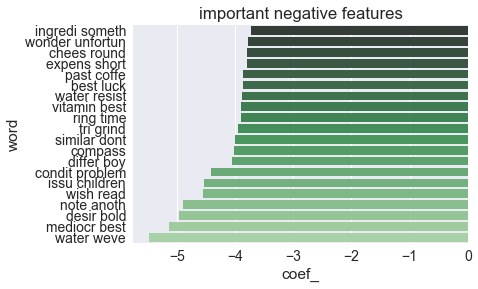

In [132]:
#visualing the negative features
sns.barplot(y='word', x='coef_', data=feature_importance.tail(20), palette="Greens_d").set_title('important negative features')

In [133]:
summary=pd.DataFrame({"gridsearchcv":["100","L2"],"randomizedsearchcv":["90","L2"]},index=["C","regularization"])
summary.T

,C,regularization
gridsearchcv,100,L2
randomizedsearchcv,90,L2


The model performs good for bag of words

# Tfidf

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
#splitting
x_1, x_test, y_1, y_test = train_test_split(d.cleaned.values, d.Score, test_size=0.3, random_state=0,shuffle=False)


In [28]:
tfidf=TfidfVectorizer(ngram_range=(1,2))

In [72]:
#transforming the data and normalizing
tdata=tfidf.fit_transform(x_1)
tdata=preprocessing.normalize(tdata)
test_data=tfidf.transform(x_test)
test_data=preprocessing.normalize(test_data)
print(tdata.shape,test_data.shape)

(254919, 2351241) (109252, 2351241)


In [138]:
#gridsearchcv for finding optimal c
lr = LogisticRegression()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100],"penalty":["l1","l2"]} 
#For time based splitting
t = TimeSeriesSplit(n_splits=5) 
    
gsv = GridSearchCV(lr,param_grid,cv=t,n_jobs=-1,verbose=1,scoring="f1")
gsv.fit(tdata,y_1)
print("Best HyperParameter: ",gsv.best_params_)
#assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("best estimator: ",gsv.estimator)
    

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  9.1min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l2'}
best estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [139]:
gsv.best_score_*100

95.881560903948

In [140]:
gsv.cv_results_

C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\

{'mean_fit_time': array([ 10.83135114,  15.52902765,  18.80591683,  18.03613682,
         30.0579565 ,  26.55556188,  46.33152084,  43.05567989,
         54.47191563,  66.16227899, 116.95815043, 106.12292461,
        133.90091906,  89.25948577]),
 'std_fit_time': array([ 8.77987927,  6.67995435,  6.31384052,  6.27018968, 17.19573239,
        11.20526836, 17.15118712, 20.45784888, 23.32192273, 32.78727172,
        34.73263094, 50.81945423, 43.94987548, 27.56192968]),
 'mean_score_time': array([0.16983318, 0.33866196, 0.18420677, 0.1710062 , 0.18557477,
        0.18648515, 0.18425741, 0.19670715, 0.18640232, 0.22183523,
        0.19661117, 0.20786991, 0.13647561, 0.11973615]),
 'std_score_time': array([0.10261496, 0.26277737, 0.02368178, 0.03001298, 0.055409  ,
        0.02765762, 0.02928589, 0.02315976, 0.01824364, 0.01926342,
        0.04302977, 0.03075364, 0.03885573, 0.05725366]),
 'param_C': masked_array(data=[0.0001, 0.0001, 0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1,
                  

In [141]:
#separating the values of regulerization
mean_test_score=gsv.cv_results_["mean_test_score"]
mean_test_score=1-mean_test_score
y_l1=[]
y_l2=[]
for i in mean_test_score[0:14:2]:
    y_l1.append(i)
for i in mean_test_score[1:14:2]:
    y_l2.append(i)
print(y_l1)
print("\n\n")
print(y_l2)

[0.08524499261752805, 0.08524499261752805, 0.08519099054896606, 0.06633951990852582, 0.04561982694223621, 0.04264709122839683, 0.04431391213889535]



[0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.07792516634021995, 0.0520627897955962, 0.042760045170896044, 0.041184390960519957]


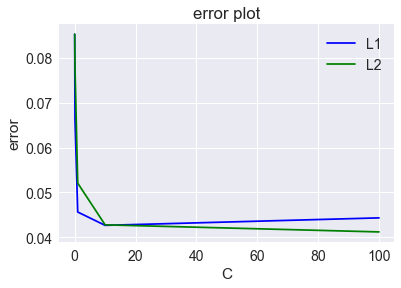

In [142]:
x=param_grid["C"]
plt.plot(x,y_l1,"b",label="L1")
plt.plot(x,y_l2,"g",label="L2")
plt.xlabel("C")
plt.ylabel("error")
plt.title("error plot")
plt.legend()
plt.show()

now lets try the optimal parameteres on the test data

In [143]:
lr=LogisticRegression(C=100,penalty="l2")
lr.fit(tdata,y_1)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [144]:
pred=lr.predict(test_data)


the accuracy is 93.46%

the recall is 97.60%
the precision is 94.65%
the f1 score is 96.10%


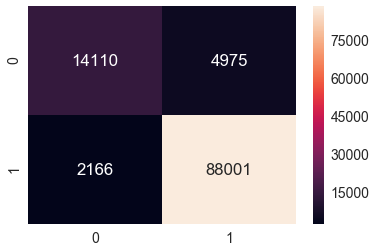

In [145]:
acc=accuracy_score(y_test,pred)*100
print("\nthe accuracy is %.2f%%"%acc)
    
re=recall_score(y_test,pred,) * 100
print("\nthe recall is %.2f%%"%re)
    
pre=precision_score(y_test,pred) * 100
print("the precision is %.2f%%"%pre)
    
f1=f1_score(y_test,pred) * 100
print("the f1 score is %.2f%%"%f1)

df_cm=pd.DataFrame(confusion_matrix(y_test,pred))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,fmt="d")

In [146]:
scoring_data=pd.DataFrame({"accuracy":"93.46%","recall":"97.60%","precision":"94.65%","f1":"96.10%"},index=["score"])
scoring_data.T

,score
accuracy,93.46%
recall,97.60%
precision,94.65%
f1,96.10%


lets see what happens to sparsity with increase in lambda or decrease in C

In [147]:
lr=LogisticRegression(C=10,penalty="l1")
lr.fit(tdata,y_1)
np.count_nonzero(lr.coef_)

31092

In [148]:
lr=LogisticRegression(C=1,penalty="l1")
lr.fit(tdata,y_1)
np.count_nonzero(lr.coef_)

2737

In [149]:
lr=LogisticRegression(C=0.1,penalty="l1")
lr.fit(tdata,y_1)
np.count_nonzero(lr.coef_)

347

In [150]:
lr=LogisticRegression(C=0.01,penalty="l1")
lr.fit(tdata,y_1)
np.count_nonzero(lr.coef_)

20

sparsity increases with increase in lambda

In [151]:
#randomizedsearchcv for finding optimal c
lr = LogisticRegression()
param_grid = {'C':randint(10**-2, 10**2),"penalty":["l1","l2"]} 
#For time based splitting
t = TimeSeriesSplit(n_splits=5) 
    
rsv = RandomizedSearchCV(lr,param_grid,cv=t,n_jobs=-1,verbose=1)
rsv.fit(tdata,y_1)
print("Best HyperParameter: ",rsv.best_params_)
#assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("best estimator: ",rsv.estimator)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.2min finished


Best HyperParameter:  {'C': 95, 'penalty': 'l2'}
best estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


# Pertubation technique
<br>multicollinearity check

In [152]:
#before noise
clf=LogisticRegression()
clf.fit(tdata,y_1)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [153]:
#nonzero values
np.count_nonzero(clf.coef_)

2351241

In [154]:
wt_test=find(clf.coef_[0])[2]
print(wt_test[0:20])

[ 0.04645525  0.04744264  0.00053778  0.17007897  0.12798862  0.00935973
 -0.04212703  0.00659661  0.01312656  0.00701524  0.00392476  0.00213447
  0.0492709   0.00070833  0.0033779   0.0033779   0.01774095  0.01774095
  0.00050136  0.00050136]


In [155]:
#generating random noise for adding to nonzero value
tdata_t=tdata
epsilon = np.random.uniform(low=-0.001, high=0.001, size=(find(tdata_t)[0].size,))
i,j,v=find(tdata_t)
print(epsilon)

[-0.00039151 -0.00071995  0.00052939 ... -0.00093318 -0.00011491
  0.00067021]


In [156]:
#addition of noise
tdata_t[i,j] = epsilon + tdata_t[i,j]

In [157]:
cl=LogisticRegression()
cl.fit(tdata_t,y_1)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [158]:
np.count_nonzero(clf.coef_)

2351241

In [159]:
wt_test_noise=find(cl.coef_[0])[2]
print(wt_test_noise[0:20])

[ 0.04579204  0.04705734  0.00057517  0.17021508  0.1278883   0.00933912
 -0.04190056  0.0065739   0.01337778  0.00713104  0.00397958  0.00215312
  0.04955252  0.00070725  0.00334899  0.00332952  0.01773055  0.01776998
  0.00050474  0.00050525]


The difference is very small.so, the feadtures are not multicollinear

# Feature importance
<br> as the features are not multicollinear we can use L1 regularizaiton

In [160]:
tf=TfidfVectorizer(ngram_range=(1,2),stop_words="english",analyzer='word')
feature_data=tf.fit_transform(x_1)
all_feat = tf.get_feature_names()

In [161]:
clf=LogisticRegression(C=1,penalty="l1")
clf.fit(feature_data,y_1)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [162]:
#converting array to 1D
check=clf.coef_.ravel()

In [163]:
#creating dataframe for feature importance
feature_importance=pd.DataFrame({"word":all_feat,"coef_":check})
feature_importance.head(4)

,word,coef_
0,aa,0.0
1,aa pleas,0.0
2,aa state,0.0
3,aaa,0.0


In [164]:
#sorting in descending order
feature_importance.sort_values(by="coef_",ascending=False,inplace=True)
feature_importance.head(10)

,word,coef_
919679,high recommend,30.415174
849395,great,26.614199
518289,delici,25.806726
167357,best,23.982681
1407016,perfect,23.296294
1442136,pleasant surpris,21.142059
665793,excel,20.791440
2170289,wont disappoint,20.072441
1142736,love,20.056110
55385,amaz,18.324004


Text(0.5,1,'important positive features ')

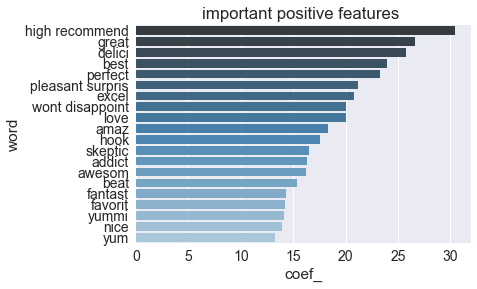

In [165]:
#visualising positive features
sns.barplot(y='word', x='coef_', data=feature_importance.head(20), palette="Blues_d").set_title('important positive features ')

Text(0.5,1,'important positive features ')

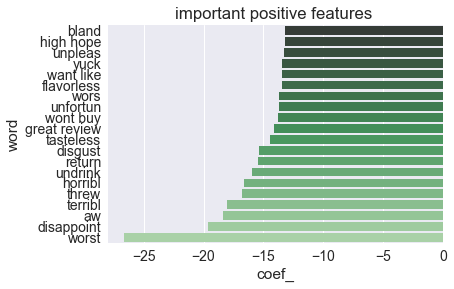

In [166]:
#visualising negative features
sns.barplot(y='word', x='coef_', data=feature_importance.tail(20), palette="Greens_d").set_title('important positive features ')

In [167]:
summary=pd.DataFrame({"gridsearchcv":["100","L2"],"randomizedsearchcv":["90","L2"]},index=["C","regularization"])
summary.T

,C,regularization
gridsearchcv,100,L2
randomizedsearchcv,90,L2


The model performs quiet good

# Word2vec

In [26]:
from gensim.models import Word2Vec
#making list of sentences
import string
i=0
list_s=[]
for s in d.Text.values:
    filtered=[]
    s=cleanhtml(s)
    for w in s.split():
        for c_w in cleanpunc(w).split():
            if c_w.isalpha():
                filtered.append(c_w.lower())
            else:
                continue
    list_s.append(filtered)
#training our own model
w2v_model=Word2Vec(list_s,min_count=3,size=100,workers=8)

C:\Users\himateja\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [27]:
#splitting the data
x_1, x_test, y_1, y_test = train_test_split(list_s, d.Score, test_size=0.3, random_state=0,shuffle=False)

# Avg Word2vec

In [32]:
def avg(l):
    
    sv=[]
    for s in l:
        sum=np.zeros(100)
        i=0
        for w in s:
            try:
            
                x=w2v_model.wv[w]
                sum+=x
                i+=1
            except:
                pass
        sum/=i
        sv.append(sum)
    return np.matrix(sv)
    


In [33]:
x_1=avg(x_1)

In [34]:
np.asarray(x_1).shape

(254919, 100)

In [35]:
x_test=avg(x_test)

C:\Users\himateja\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [36]:
np.asarray(x_test).shape

(109252, 100)

In [37]:
#changing nan values if any
train=np.nan_to_num(x_1)
test=np.nan_to_num(x_test)


In [39]:
#gridsearchcv
lr = LogisticRegression()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100],"penalty":["l1","l2"]} 
#For time based splitting
t = TimeSeriesSplit(n_splits=5) 
    
gsv = GridSearchCV(lr,param_grid,cv=t,n_jobs=-1,verbose=1,scoring="f1")
gsv.fit(train,y_1)
print("Best HyperParameter: ",gsv.best_params_)
#assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("best estimator: ",gsv.estimator)
    

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 53.8min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l2'}
best estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [40]:
gsv.best_score_*100

94.00437890007348

In [41]:
gsv.cv_results_

C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\

{'mean_fit_time': array([   1.82420626,    5.17689247,   11.61071754,   13.99503365,
          72.01259899,   24.47782598,  111.85185399,   29.52089338,
         929.04287481,   51.19140778, 1674.16242766,   74.27691922,
        1274.37865739,   76.73539486]),
 'std_fit_time': array([  1.37291477,   4.06143855,  11.27843786,   9.45654506,
         49.05016703,  14.42840945,  32.76317173,  14.57023775,
        671.70342801,  31.7737272 , 773.63057706,  38.69139384,
        366.71351344,  37.31782253]),
 'mean_score_time': array([0.36877189, 0.2120688 , 0.09028049, 0.11553512, 0.1265851 ,
        0.12145357, 0.15880523, 0.06650476, 0.18492413, 0.06358924,
        0.16934791, 0.05960207, 0.06608438, 0.0531136 ]),
 'std_score_time': array([0.20715121, 0.2649323 , 0.05319222, 0.05776915, 0.03230567,
        0.09569468, 0.07903959, 0.01088597, 0.15404245, 0.01146809,
        0.04554848, 0.00614829, 0.03182982, 0.00765296]),
 'param_C': masked_array(data=[0.0001, 0.0001, 0.001, 0.001, 0.01, 0

In [42]:
#separating the l1 and l2 values
mean_test_score=gsv.cv_results_["mean_test_score"]
mean_test_score=1-mean_test_score
y_l1=[]
y_l2=[]
for i in mean_test_score[0:14:2]:
    y_l1.append(i)
for i in mean_test_score[1:14:2]:
    y_l2.append(i)
print(y_l1)
print("\n\n")
print(y_l2)

[0.08533665718223216, 0.07964863606371586, 0.06354612686837757, 0.06035847342606504, 0.06006661715558015, 0.060012820364547914, 0.05999178671175853]



[0.08374508708523853, 0.0700839115999966, 0.061501063760627916, 0.0602301498629757, 0.06001650006946502, 0.059995866149874955, 0.05995621099926529]


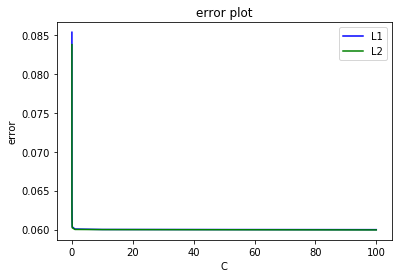

In [43]:
#error plot
x=param_grid["C"]
plt.plot(x,y_l1,"b",label="L1")
plt.plot(x,y_l2,"g",label="L2")
plt.xlabel("C")
plt.ylabel("error")
plt.title("error plot")
plt.legend()
plt.show()

lets apply best hyperparameter in action

In [45]:
lr=LogisticRegression(C=100,penalty="l2")
lr.fit(train,y_1)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
pred=lr.predict(test)


the accuracy is 89.00%

the recall is 96.47%
the precision is 90.77%
the f1 score is 93.54%


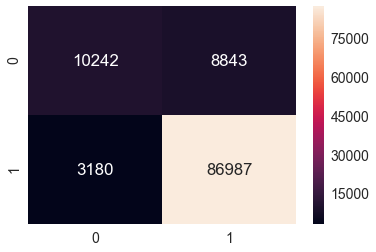

In [47]:
acc=accuracy_score(y_test,pred)*100
print("\nthe accuracy is %.2f%%"%acc)
    
re=recall_score(y_test,pred,) * 100
print("\nthe recall is %.2f%%"%re)
    
pre=precision_score(y_test,pred) * 100
print("the precision is %.2f%%"%pre)
    
f1=f1_score(y_test,pred) * 100
print("the f1 score is %.2f%%"%f1)

df_cm=pd.DataFrame(confusion_matrix(y_test,pred))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,fmt="d")

In [48]:
scoring_data=pd.DataFrame({"accuracy":"89.00%","recall":"96.47%","precision":"90.77%","f1":"93.54%"},index=["score"])
scoring_data.T

,score
accuracy,89.00%
recall,96.47%
precision,90.77%
f1,93.54%


lets see what happens to sparsity with increase in lambda

In [49]:
lr=LogisticRegression(C=10,penalty="l1")
lr.fit(train,y_1)
np.count_nonzero(lr.coef_)

99

In [50]:
lr=LogisticRegression(C=1,penalty="l1")
lr.fit(train,y_1)
np.count_nonzero(lr.coef_)

100

In [51]:
lr=LogisticRegression(C=.1,penalty="l1")
lr.fit(train,y_1)
np.count_nonzero(lr.coef_)

97

In [52]:
lr=LogisticRegression(C=.01,penalty="l1")
lr.fit(train,y_1)
np.count_nonzero(lr.coef_)

81

sparsity increases with increase in lambda

In [38]:
#randomizedsearchcv
lr = LogisticRegression()
param_grid = {'C':randint(10**-2, 10**2),"penalty":["l1","l2"]} 
#For time based splitting
t = TimeSeriesSplit(n_splits=3) 
    
rsv = RandomizedSearchCV(lr,param_grid,cv=t,n_jobs=-1,verbose=1)
rsv.fit(train,y_1)
print("Best HyperParameter: ",rsv.best_params_)
#assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("best estimator: ",rsv.estimator)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 49.3min finished


Best HyperParameter:  {'C': 33, 'penalty': 'l1'}
best estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


# Pertubation technique
<br>multicollinearity check

In [38]:
clf=LogisticRegression()
clf.fit(train,y_1)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
wt_test=find(clf.coef_[0])[2]
print(wt_test[0:20])

[-0.07323414 -0.27828451  0.27906553 -1.57250832  0.00744133 -0.3886471
  1.18881694 -0.15708664 -2.49435854  0.56476661  0.16660721 -0.32184196
 -1.32037805 -0.68279559  1.28570245  0.50028978  1.10845098  1.63209455
  0.33067109  1.66735704]


In [40]:
x_1_t=train
epsilon = np.random.uniform(low=-0.001, high=0.001, size=(find(x_1_t)[0].size,))
i,j,v=find(x_1_t)
print(epsilon)

[ 7.52625773e-04  8.58448417e-05 -8.90916048e-04 ...  7.79184291e-04
  5.51188742e-05  1.84753387e-04]


In [41]:
x_1_t[i,j] = epsilon + x_1_t[i,j]

In [42]:
clf=LogisticRegression()
clf.fit(x_1_t,y_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
wt_test_noise=find(clf.coef_[0])[2]
print(wt_test_noise[0:20])

[-0.07950654 -0.27767067  0.27879303 -1.56715728  0.00895534 -0.39113137
  1.18629003 -0.1553853  -2.48665692  0.56516244  0.16581946 -0.31727856
 -1.31674371 -0.67986191  1.27892829  0.49484372  1.10606222  1.62444072
  0.33085647  1.6653512 ]


the differences are not significant ,so the features are not multicollinear .

In [39]:
summary=pd.DataFrame({"gridsearchcv":["100","L2"],"randomizedsearchcv":["33","L1"]},index=["C","regularization"])
summary.T

,C,regularization
gridsearchcv,100,L2
randomizedsearchcv,33,L1


# Tfidf word2vec

In [30]:
#splitting the data
x_1, x_test, y_1, y_test = train_test_split(list_s, d.Score, test_size=0.3, random_state=0,shuffle=False)



In [35]:
def tf(l):
    
    tf=tfidf.fit_transform(d.Text.values)
    tfidfsv = []
    row=0;
    for s in l: 
        sum = np.zeros(100) 
        i=0; 
        for word in s: 
            try:
                vec = w2v_model.wv[word]
                tf_idf = tf[row, tfidf_feat.index(word)]
                sum += (vec * tf_idf)
                i += tf_idf
            except:
                pass
        sum /= i
        tfidfsv.append(sum)
        row += 1
    return np.matrix(tfidfsv)

In [36]:
x_1=tf(x_1)
x_test=tf(x_test)

C:\Users\himateja\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [37]:
x_1.shape

(254919, 100)

In [38]:
x_test.shape

(109252, 100)

In [39]:
# changing 'NaN' to numeric value
train=np.nan_to_num(x_1)
test=np.nan_to_num(x_test)

In [40]:
#gridsearchcv
lr = LogisticRegression()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000],"penalty":["l1","l2"]} 
#For time based splitting
t = TimeSeriesSplit(n_splits=5) 
    
gsv = GridSearchCV(lr,param_grid,cv=t,n_jobs=-1,verbose=1,scoring="f1")
gsv.fit(train,y_1)
print("Best HyperParameter: ",gsv.best_params_)
#assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("best estimator: ",gsv.estimator)
    

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   52.8s finished


Best HyperParameter:  {'C': 0.0001, 'penalty': 'l1'}
best estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [41]:
gsv.best_score_*100

91.47550073824719

In [42]:
gsv.cv_results_

C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\himateja\Anaconda3\lib\site-packages\

{'mean_fit_time': array([0.23102555, 0.33412066, 0.18644729, 0.20176568, 0.19043493,
        0.21051254, 0.1932735 , 0.20255175, 0.19133444, 0.2062726 ,
        0.18819561, 0.19797201, 0.18400493, 0.20909319, 0.18830342,
        0.1896594 ]),
 'std_fit_time': array([0.12718135, 0.19146447, 0.07781272, 0.08411555, 0.08490833,
        0.09446302, 0.08384402, 0.08524125, 0.07560241, 0.08653175,
        0.07144923, 0.08030059, 0.07924798, 0.09758957, 0.07998598,
        0.07636206]),
 'mean_score_time': array([0.1133173 , 0.0536324 , 0.02323842, 0.02717619, 0.02344394,
        0.01939096, 0.01982226, 0.02125454, 0.01792336, 0.02138157,
        0.02029338, 0.02436676, 0.02497997, 0.02200618, 0.01485105,
        0.0224093 ]),
 'std_score_time': array([0.04531472, 0.04308841, 0.00697962, 0.00606385, 0.00727868,
        0.00598147, 0.00587935, 0.00692319, 0.00407862, 0.00858828,
        0.00623336, 0.00845137, 0.00729369, 0.00817818, 0.00153968,
        0.00745146]),
 'param_C': masked_array(d

In [43]:
#separating regulerisation values
mean_test_score=gsv.cv_results_["mean_test_score"]
mean_test_score=1-mean_test_score
y_l1=[]
y_l2=[]
for i in mean_test_score[0:16:2]:
    y_l1.append(i)
for i in mean_test_score[1:16:2]:
    y_l2.append(i)
print(y_l1)
print("\n\n")
print(y_l2)

[0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805]



[0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805, 0.08524499261752805]


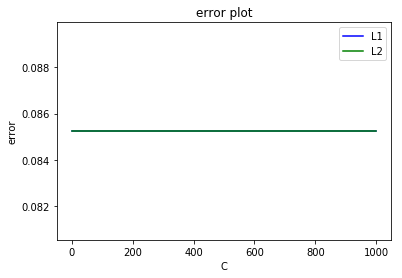

In [44]:
#error plot
x=param_grid["C"]
plt.plot(x,y_l1,"b",label="L1")
plt.plot(x,y_l2,"g",label="L2")
plt.xlabel("C")
plt.ylabel("error")
plt.title("error plot")
plt.legend()
plt.show()

lets use the optimal value of c and see how it performs

In [45]:
lr=LogisticRegression(C=0.0001,penalty="l1")
lr.fit(train,y_1)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [46]:
pred=lr.predict(test)


the accuracy is 82.53%

the recall is 100.00%
the precision is 82.53%
the f1 score is 90.43%


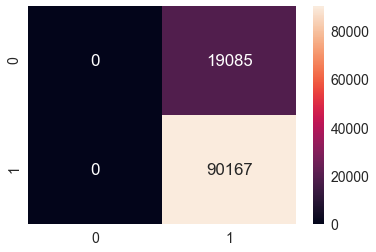

In [47]:
acc=accuracy_score(y_test,pred)*100
print("\nthe accuracy is %.2f%%"%acc)
    
re=recall_score(y_test,pred,) * 100
print("\nthe recall is %.2f%%"%re)
    
pre=precision_score(y_test,pred) * 100
print("the precision is %.2f%%"%pre)
    
f1=f1_score(y_test,pred) * 100
print("the f1 score is %.2f%%"%f1)

df_cm=pd.DataFrame(confusion_matrix(y_test,pred))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,fmt="d")

In [41]:
scoring_data=pd.DataFrame({"accuracy":"82.53%","recall":"100%","precision":"82.53%","f1":"90.43%"},index=["score"])
scoring_data.T

,score
accuracy,82.53%
recall,100%
precision,82.53%
f1,90.43%


lets check whats happening to sparsity with increase in lambda

In [49]:
lr=LogisticRegression(C=10,penalty="l1")
lr.fit(train,y_1)
np.count_nonzero(lr.coef_)

0

In [50]:
lr=LogisticRegression(C=1,penalty="l1")
lr.fit(train,y_1)
np.count_nonzero(lr.coef_)

0

In [51]:
lr=LogisticRegression(C=.1,penalty="l1")
lr.fit(train,y_1)
np.count_nonzero(lr.coef_)

0

In [52]:
lr=LogisticRegression(C=.01,penalty="l1")
lr.fit(train,y_1)
np.count_nonzero(lr.coef_)

0

there is no weight in vectors this is the reason it is behaving as dumb model and it is not useful to do pertubation test as there is no weight.

Randomizedsearchcv

In [54]:
#randomizedsearchcv
lr = LogisticRegression()
param_grid = {'C':randint(10**-2, 10**2),"penalty":["l1","l2"]} 
#For time based splitting
t = TimeSeriesSplit(n_splits=5) 
    
rsv = RandomizedSearchCV(lr,param_grid,cv=t,n_jobs=-1,verbose=1)
rsv.fit(train,y_1)
print("Best HyperParameter: ",rsv.best_params_)
#assinging best alpha to optimal print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
print("best estimator: ",rsv.estimator)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.2s finished


Best HyperParameter:  {'C': 95, 'penalty': 'l1'}
best estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [40]:
summary=pd.DataFrame({"gridsearchcv":["0.0001","L2"],"randomizedsearchcv":["95","L1"]},index=["C","regularization"])
summary.T

,C,regularization
gridsearchcv,0.0001,L2
randomizedsearchcv,95,L1


This model is dumb . it has very poor performance.

# conclusion:
   <br>1.The sparcity increases with increase in lambda.
   <br>2.L1 is very useful when the features are not multicollinear.